In [2]:
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import describe
import datetime
from datetime import timedelta as timedelta
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
import sklearn.utils as sku
from scipy import signal
import os, sys
sys.path.append( '/home/ugrads/c/clearloveyanzhen/CufflessBP/bioz_processing' )
import sicong_util as su
import sicong_duck_path as sp
import sicong_duck_path as sdp
plt.rcParams.update({'font.size': 13})
import seaborn as sns
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader , TensorDataset
import torch.autograd as autograd
from torch import Tensor
from sklearn import svm
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression

/home/ugrads/c/clearloveyanzhen/miniconda3/envs/torch/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [284]:
def label_binary_converter(in_x, in_y, bp_type='sbp', in_vals=[140, 150], thre=[-3, +3], out_vals=[0,1], balanced_out=True, resample=False):
    # in_x=X; in_y=y; bp_type='sbp'; in_vals=[120, 160]; thre=[-2, +2]; out_vals=[0,1]; balanced_out=True
    if len(in_y.shape) == 2:
        if bp_type == 'sbp':
            in_y=in_y[:,0]
        else:
            in_y=in_y[:,1]
    if in_vals[0] == 0:
        out_y=np.where((in_y >= in_vals[1]+thre[0])&(in_y <= in_vals[1]+thre[1]), out_vals[1], out_vals[0])
        out_x=in_x
    else:
        out_y=in_y[((in_y >= in_vals[0]+thre[0])&(in_y <= in_vals[0]+thre[1])) | ((in_y >= in_vals[1]+thre[0])&(in_y <= in_vals[1]+thre[1]))]
        out_y=np.where(out_y < in_vals[1]+thre[0], 0, 1)
        out_x=in_x[((in_y >= in_vals[0]+thre[0])&(in_y <= in_vals[0]+thre[1])) | ((in_y >= in_vals[1]+thre[0])&(in_y <= in_vals[1]+thre[1]))]
    if balanced_out:
        len_out=min(np.count_nonzero(out_y==out_vals[1]), np.count_nonzero(out_y==out_vals[0]))
        print(np.count_nonzero(out_y==out_vals[1]), np.count_nonzero(out_y==out_vals[0]))
        num_lab = [0,0]
        index_list = []
        for i, e in enumerate(out_y):
            if num_lab[0] >= len_out and num_lab[1] >= len_out:
                break
            if e==0 and num_lab[0]<len_out:
                index_list.append(i)
                num_lab[0]+=1
            if e==1 and num_lab[1]<len_out:
                index_list.append(i)
                num_lab[1]+=1
        out_x = out_x[index_list]
        out_y = out_y[index_list]
    if resample:
        print('resampling')
        out_x, out_y = sku.resample(out_x, out_y)
    return out_x, out_y

def Binary_Model_Runner(X, y, label_list = [120, 130], split_size=0.2, resample=True, show_visual=True):
    if resample:
        print('resampling')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=42)
    else:
        X_train, X_test = X[:int(X.shape[0]*(1-split_size)), :], X[int(X.shape[0]*(1-split_size)):, :]
        y_train, y_test = y[:int(X.shape[0]*(1-split_size))], y[int(X.shape[0]*(1-split_size)):]
        
    # lr = LogisticRegression(random_state=0)
    xgb = xgboost.XGBClassifier(objective='binary:logistic', eval_metric='logloss', max_depth=3, use_label_encoder=False)
    models_used = {'xgb':xgb}
    model_names = {'xgb':'XGBoost'}
    colors_used = {'xgb': 'blue'}
    scores = {}
    for model in models_used:
        scores[model] = cross_val_score(models_used[model], X, y, cv=10, scoring='f1')
    plt.title(f'cross validation F1 Scores ({label_list[0]} vs. {label_list[1]} mmHg)')
    for model in scores:
        if show_visual:
            plt.plot(scores[model], color=colors_used[model], label=model_names[model])
            plt.axhline(np.mean(scores[model]), color=colors_used[model], label=str(np.mean(scores[model]))[:5])
            plt.ylim([0.5, 1])
        print(f'{model} with Average={np.mean(scores[model]):.3f} with STD={np.std(scores[model]):.3f}')
    if show_visual:
        plt.legend()
        plt.show()
    plt.close()
    for model in models_used:
        models_used[model].fit(X_train, y_train)
        y_pred = models_used[model].predict(X_test)
        print(f'result of one prediction={f1_score(y_test, y_pred):.3f} with resample={resample}')
        if show_visual:
            plot_confusion_matrix(models_used['xgb'], X_test, y_test, display_labels=[str(label_list[0]), str(label_list[1])])
            plt.title('Confusion Matrix of BP Classification from BioZ Waveform')
            plt.show()
    return models_used, scores
def train_FSM_model(X, y, norm_list=[120, 130, 140, 150, 160], bp_type='sbp', split_size=0.33, resample=False):
    xgboost_dict = {}
    for norm in norm_list:
        pair = [0, norm]
        bin_x, bin_y = label_binary_converter(in_x=X, in_y=y, in_vals=pair, bp_type=bp_type, balanced_out=True, resample=True)
        print(bin_x.shape, bin_y.shape)
        models_used, scores = Binary_Model_Runner(X=bin_x, y=bin_y, label_list=pair, split_size=split_size, resample=resample, show_visual=False)
        xgboost_dict[norm] = models_used['xgb']
    return xgboost_dict
def test_FSM_model(X_test, y_stage, xgboost_dict, current_stage=130, hop=5, norm_list=[120, 130, 140, 150, 160], split_size=0.2, resample=False):
    predicted_values={}
    cs = []
    print(X_test.shape, y_stage.shape)
    for index in range(0, len(y_stage), hop):
        cs.append(current_stage)
        for norm in xgboost_dict:
            if abs(current_stage-norm) <= 10:
                # print(f'model is [{norm}]')
                y_test=np.where(norm == y_stage[index:index+hop], 1, 0)
                # print(f'y_stage {y_stage}, y_test {y_test}')
                y_pred = xgboost_dict[norm].predict(X_test[index:index+hop])
                predicted_values[norm]=[]
                # print(f'y_pred {y_pred}')
                for pred in y_pred:
                    if pred == 1:
                        predicted_values[norm].append(norm)
                    else:
                        predicted_values[norm].append(0)
                # print(f'result of {norm} model={f1_score(y_test, y_pred)} with resample={resample}')
                if f1_score(y_test, y_pred) > 0.75:
                    current_stage=norm
                # plot_confusion_matrix(xgboost_dict[norm], X_test, y_test, display_labels=[str(norm), str(0)])
    return xgboost_dict, predicted_values, cs

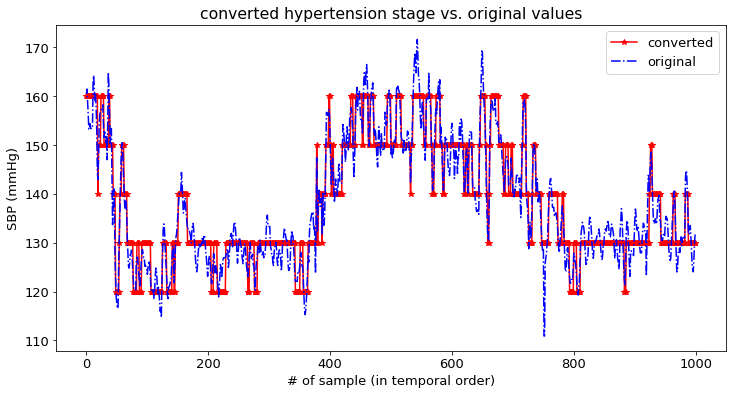

In [312]:
def stage_converter(bp_val, norm_list=[120, 130, 140, 150, 160], thre=[-3, +3], current_stage=0):
    change_stage=False
    for i, norm in enumerate(norm_list):
        if bp_val >= norm+thre[0] and bp_val <= norm+thre[1]:
            change_stage=True
            current_stage = norm
    return current_stage, change_stage
def visual_stage_plot(bp_list):
    plt.rcParams['figure.figsize'] = (12.0, 6.0)
    plot_list=[]
    stage_list=[]
    current_stage=140
    for bp_val in bp_list:
        current_stage, change_stage = stage_converter(bp_val, current_stage=current_stage)
        plot_list.append(current_stage)
        if change_stage:
            stage_list.append(current_stage)
        else:
            stage_list.append(0)
    plt.plot(plot_list[-1000:], 'r-*', label='converted')
    plt.plot(bp_list[-1000:], 'b-.', label='original')
    plt.title('converted hypertension stage vs. original values')
    plt.ylabel('SBP (mmHg)')
    plt.legend()
    plt.xlabel('# of sample (in temporal order)')
    return np.array(stage_list), np.array(plot_list)
y_stage, y_plot = visual_stage_plot(y[:,0])
# plt.plot(stage_list[:300], '.')

In [5]:
binary_pairs = []
for a in np.arange(120, 161, 10):
    for b in np.arange(a, 161, 10):
        if a != b:
            binary_pairs.append([a, b])

In [321]:
X = np.load('batched_data/X_file 75A.npy')
y = np.load('batched_data/y_file 75A.npy')
X = np.concatenate((X[:,2100:3000], X[:,-900:]), axis=1)
# mm = MinMaxScaler()
# X = mm.fit_transform(X)
# X, y = label_binary_converter(in_x=X, in_y=y)
X.shape, y.shape

((16527, 1800), (16527, 2))

In [26]:
X = X[-3000:]
y = y[-3000:]

In [102]:
len(y.shape)

2

In [145]:
X = np.load('batched_data/X_file 75A Morph.npy')
y = np.load('batched_data/y_file 75A Morph.npy')
mm = MinMaxScaler()
X = mm.fit_transform(X)
X.shape, y.shape

((17275, 69), (17275, 2))

In [103]:
X = np.load('batched_data/X_file 75E.npy')
y = np.load('batched_data/y_file 75E.npy')
X = X.reshape(len(X),-1)
X = np.concatenate((X[:,2100:3000], X[:,-900:]), axis=1)
mm = MinMaxScaler()
X = mm.fit_transform(X)
# X, y = label_binary_converter(in_x=X, in_y=y)
X.shape, y.shape

((13690, 1800), (13690, 2))

(70.0, 200.0)

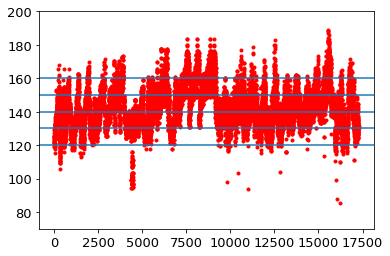

In [146]:
plt.plot(y[:,0],'r.')
plt.axhline(y=120)
plt.axhline(y=130)
plt.axhline(y=140)
plt.axhline(y=150)
plt.axhline(y=160)
plt.ylim([70, 200])

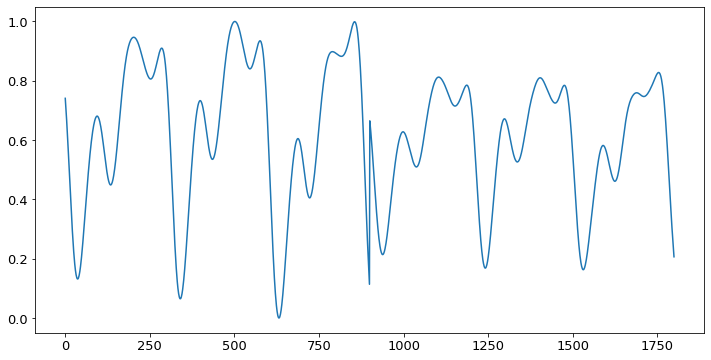

In [324]:
mm = MinMaxScaler()
te = mm.fit_transform(X[0,:].reshape(-1,1))
plt.plot(te)

In [316]:
cut_off=-1985
xgb_dict = train_FSM_model(X[:cut_off], y_plot[:cut_off])

684 14606
resampling
(1368, 69) (1368,)
xgb with Average=0.937 with STD=0.018
result of one prediction=0.931 with resample=False
3610 11680
resampling
(7220, 69) (7220,)
xgb with Average=0.825 with STD=0.016
result of one prediction=0.803 with resample=False
4914 10376
resampling
(9828, 69) (9828,)
xgb with Average=0.795 with STD=0.013
result of one prediction=0.781 with resample=False
3714 11576
resampling
(7428, 69) (7428,)
xgb with Average=0.865 with STD=0.017
result of one prediction=0.853 with resample=False
2368 12922
resampling
(4736, 69) (4736,)
xgb with Average=0.952 with STD=0.012
result of one prediction=0.950 with resample=False


In [317]:
# X.shape, y.shape, y_stage.shape
hop=1
xgb_dict, predicted_values, cs = test_FSM_model(X[cut_off:], y_plot[cut_off:], xgb_dict, hop=hop, current_stage=y_plot[cut_off])

(1985, 69) (1985,)


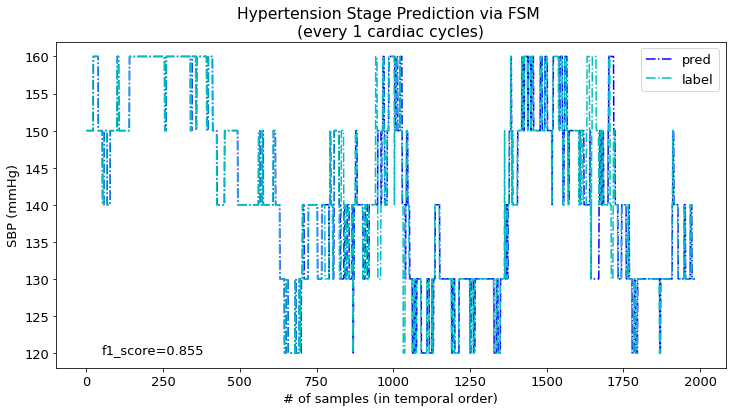

In [320]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(np.arange(0,len(cs)), cs,'b-.', label='pred')
plt.plot(np.arange(0,len(cs)), y_plot[cut_off:][::hop],'c-.', label='label')
current_score = metrics.f1_score(cs, y_plot[cut_off:][::hop], average='weighted')
plt.text(len(cs)//40, 120, f'f1_score={current_score:.3f}')
plt.title(f'Hypertension Stage Prediction via FSM \n(every {hop} cardiac cycles)')
plt.ylabel('SBP (mmHg)')
plt.xlabel('# of samples (in temporal order)')
plt.legend()# plt.plot(np.where(y_stage[-100:] == 130, 130, 1),'r-.')

In [244]:
np.arange(0,len(cs),hop).shape, np.array(cs).shape

((250,), (500,))

In [241]:
import sklearn.metrics as metrics
metrics.f1_score(cs, y_plot[-1000:-1:hop], average='weighted')

0.7516239328100056

[120, 130]
92 335
resampling
(184, 69) (184,)
resampling
xgb
Average=0.9048022015823873 with STD=0.08310055831802665


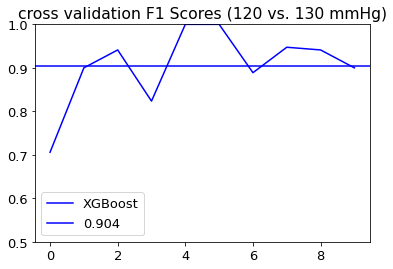

result of one prediction=0.8666666666666666 with resample=True


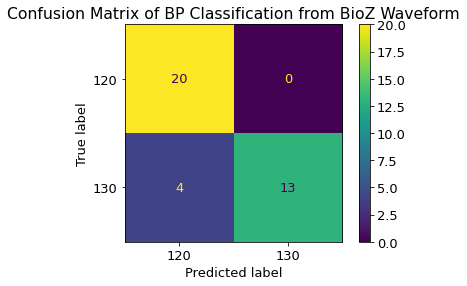

[120, 140]
92 599
resampling
(184, 69) (184,)
resampling
xgb
Average=0.9696732026143792 with STD=0.03936702823049546


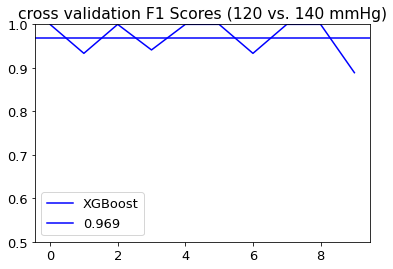

result of one prediction=1.0 with resample=True


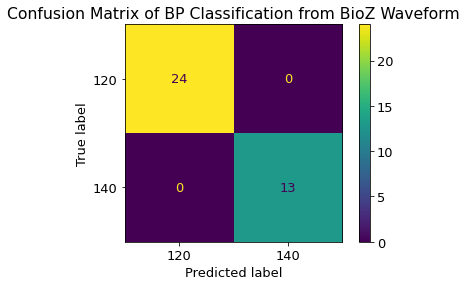

[120, 150]
92 464
resampling
(184, 69) (184,)
resampling
xgb
Average=0.9530399528232346 with STD=0.049138818796940285


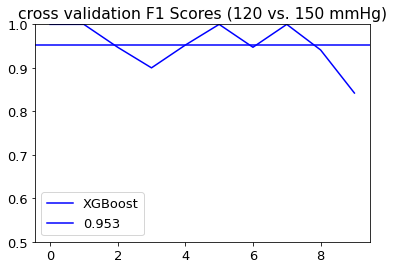

result of one prediction=1.0 with resample=True


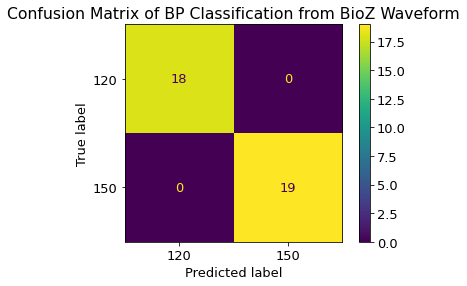

[120, 160]
92 250
resampling
(184, 69) (184,)
resampling
xgb
Average=0.9470396579684506 with STD=0.04668890646728739


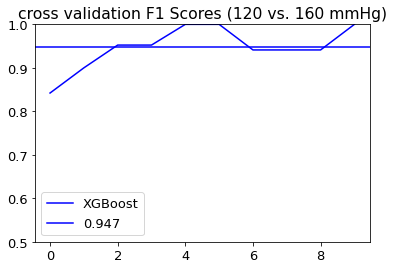

result of one prediction=0.9743589743589743 with resample=True


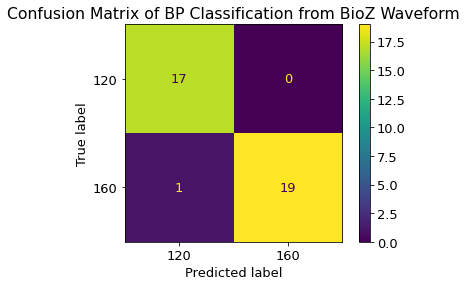

[130, 140]
335 599
resampling
(670, 69) (670,)
resampling
xgb
Average=0.9627779859029859 with STD=0.022390320950736876


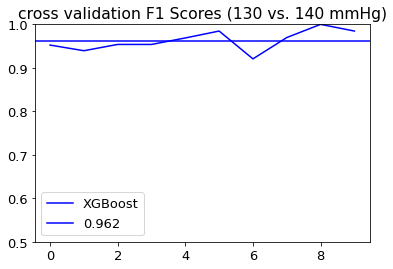

result of one prediction=0.96 with resample=True


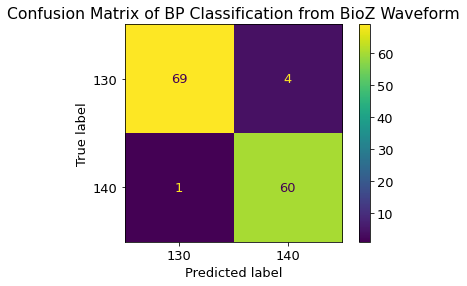

[130, 150]
335 464
resampling
(670, 69) (670,)
resampling
xgb
Average=0.9126469693155567 with STD=0.03240548052131825


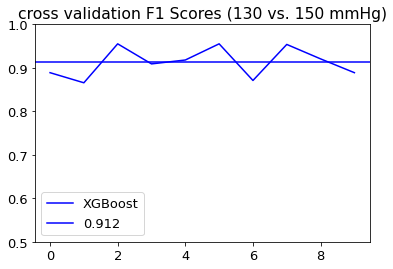

result of one prediction=0.8721804511278195 with resample=True


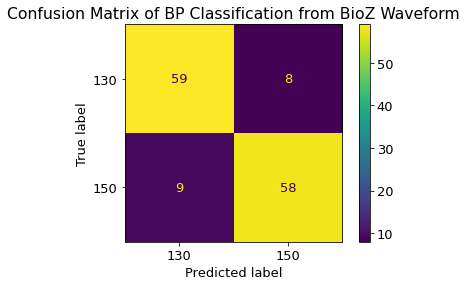

[130, 160]
335 250
resampling
(500, 69) (500,)
resampling
xgb
Average=0.9396028622191267 with STD=0.020476081767429665


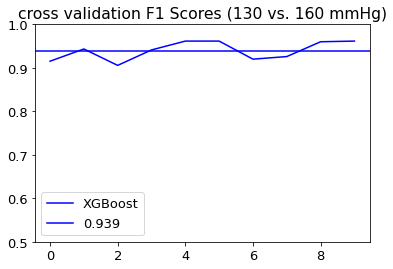

result of one prediction=0.8849557522123894 with resample=True


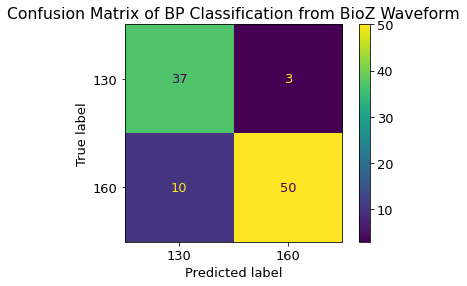

[140, 150]
599 464
resampling
(928, 69) (928,)
resampling
xgb
Average=0.9078373107509836 with STD=0.04163861326506859


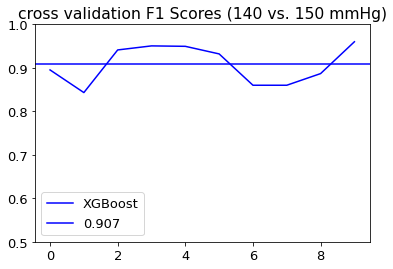

result of one prediction=0.8493150684931506 with resample=True


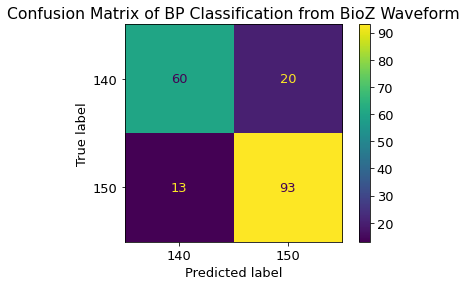

[140, 160]
599 250
resampling
(500, 69) (500,)
resampling
xgb
Average=0.9665523302047798 with STD=0.022056169979933093


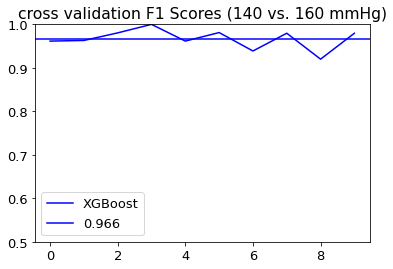

result of one prediction=0.9795918367346939 with resample=True


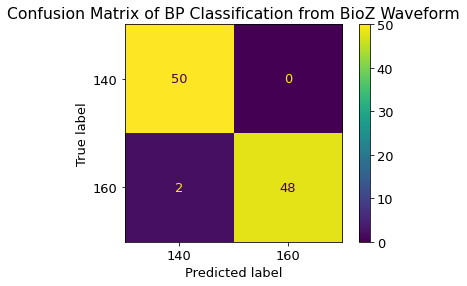

[150, 160]
464 250
resampling
(500, 69) (500,)
resampling
xgb
Average=0.8738222491061857 with STD=0.07079795398635874


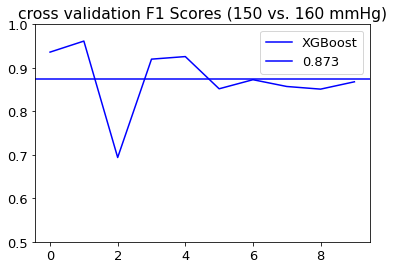

result of one prediction=0.8222222222222222 with resample=True


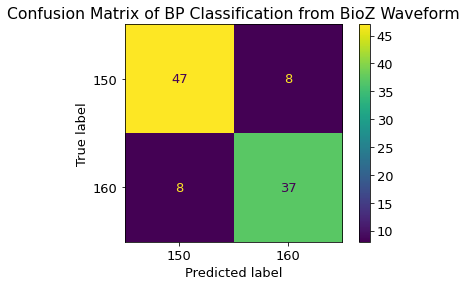

In [27]:
import warnings
warnings.filterwarnings('ignore')
for pair in binary_pairs[:]:
    print(pair)
    bin_x, bin_y = label_binary_converter(in_x=X, in_y=y, in_vals=pair, balanced_out=True, resample=True)
    print(bin_x.shape, bin_y.shape)
    models_used, scores = Binary_Model_Runner(X=bin_x, y=bin_y, label_list=pair, split_size=0.2, resample=True)

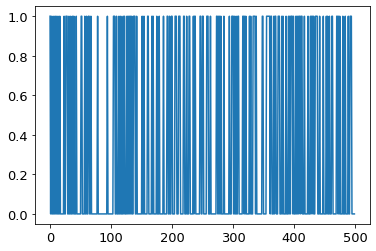

In [118]:
plt.plot(bin_y[3000:3500])

In [194]:
# for model in models_used:
#     models_used[model].fit(X_train, y_train)
#     y_pred = models_used[model].predict(X_test)
#     print(f1_score(y_test, y_pred))

0.8691392582225332


In [49]:
# plot_confusion_matrix(models_used['xgb'], X_test, y_test, display_labels=['140', '150'])
# plt.title('Confusion Matrix of subset of data')

In [452]:
models_used['xgb']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=48,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [453]:
import shap
shap.__version__

'0.39.0'

In [465]:
explainer = shap.Explainer(models_used['xgb'])
shap_test = explainer(bin_x[:100,:])
print(f"Length of shap_test: {len(shap_test)}\n")
print(f"Sample shap_test:\n{shap_test[2,:]}")

Length of shap_test: 100

Sample shap_test:
.values =
array([-0.0777137 ,  0.16994889, -0.03984185, -0.10104384,  0.02201215,
       -0.02921808, -0.20786677,  0.20056503,  0.07775002, -0.12988712,
       -0.07642762,  0.0015968 , -0.08717692, -0.04498336, -0.03883564,
       -0.0941646 ,  0.09982321,  0.11548638, -0.23611988, -0.08563559,
        0.20966834,  0.06233772, -0.12251183,  0.35445383,  0.20090757,
        0.08823585,  0.09953068,  0.04425855,  0.13518646, -0.02994797,
       -0.15671974,  0.34349203, -0.10967305,  0.566505  , -0.02579342,
        0.28783098, -0.35379755, -0.13680044, -0.08695319,  0.16622554,
        0.09433437, -0.02777039, -0.07015759, -0.3430385 , -0.03362549,
       -0.06433091,  1.3315036 ,  0.10647855,  0.09488964,  0.00927136,
        0.29722336, -0.02424682, -0.11841305,  0.15785186,  0.06354542,
        0.07481525, -0.01157993, -0.15888275,  0.23408848, -0.02750261,
        0.23776667, -0.04893617, -0.30666962, -0.00890722,  0.12920193,
        0.

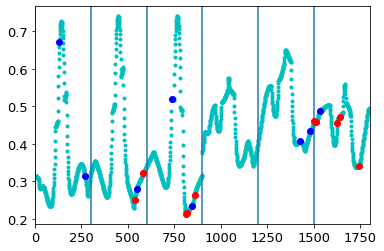

In [279]:
val_name=[1642, 815, 1514, 859, 537, 1745, 820, 1503, 584, 1626, 132, 270, 845, 1482, 737, 1426, 1534, 548]
# val_name=[845,487,1644,851,537,1426,516,831,131,1799,859,607,1427,132,1294,161,437,73,985,1534,680,426,860]
bin_x[1,:] = bin_x[2,:]
plt.plot(signal_sample, 'c.')
plt.xlim([0,1800])
for each in np.arange(1,len(signal_sample), 300):
    plt.axvline(each)
plt.plot(val_name[:10], signal_sample[val_name[:10]], 'ro')
plt.plot(val_name[10:], signal_sample[val_name[10:]], 'bo')

In [261]:
bin_x[1,:].shape

(1800,)

Feature 0 = ptt
Feature 1 = ch1_ms_ibi
Feature 2 = ch1_dia_to_ms_td
Feature 3 = ch1_dia_to_sys_td
Feature 4 = ch1_dia_to_ip_td
Feature 5 = ch1_dia_to_ms_ad
Feature 6 = ch1_dia_to_sys_ad
Feature 7 = ch1_dia_to_ip_ad
Feature 8 = ch1_dia_to_ms_integrate
Feature 9 = ch1_dia_to_sys_integrate
Feature 10 = ch1_dia_to_ip_integrate
Feature 11 = ch1_dia_to_dia2_integrate
Feature 12 = ch2_ms_ibi
Feature 13 = ch2_dia_to_ms_td
Feature 14 = ch2_dia_to_sys_td
Feature 15 = ch2_dia_to_ip_td
Feature 16 = ch2_dia_to_ms_ad
Feature 17 = ch2_dia_to_sys_ad
Feature 18 = ch2_dia_to_ip_ad
Feature 19 = ch2_dia_to_ms_integrate
Feature 20 = ch2_dia_to_sys_integrate
Feature 21 = ch2_dia_to_ip_integrate
Feature 22 = ch2_dia_to_dia2_integrate
Feature 23 = ptt
Feature 24 = ch1_ms_ibi
Feature 25 = ch1_dia_to_ms_td
Feature 26 = ch1_dia_to_sys_td
Feature 27 = ch1_dia_to_ip_td
Feature 28 = ch1_dia_to_ms_ad
Feature 29 = ch1_dia_to_sys_ad
Feature 30 = ch1_dia_to_ip_ad
Feature 31 = ch1_dia_to_ms_integrate
Feature 32 = ch1_di

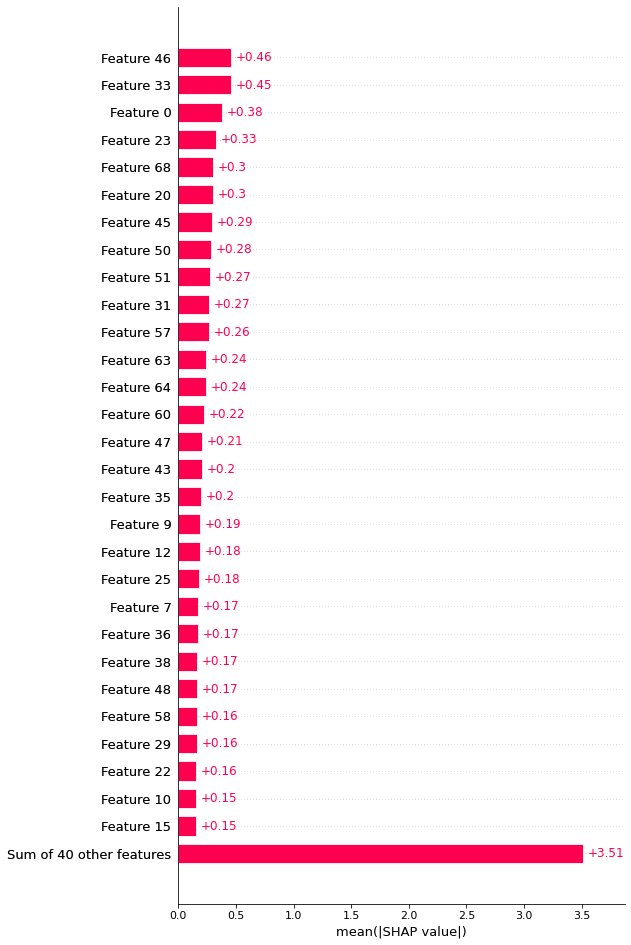

In [467]:
name_list=['ptt','ch1_ms_ibi','ch1_dia_to_ms_td','ch1_dia_to_sys_td','ch1_dia_to_ip_td','ch1_dia_to_ms_ad','ch1_dia_to_sys_ad','ch1_dia_to_ip_ad','ch1_dia_to_ms_integrate','ch1_dia_to_sys_integrate','ch1_dia_to_ip_integrate','ch1_dia_to_dia2_integrate','ch2_ms_ibi','ch2_dia_to_ms_td','ch2_dia_to_sys_td','ch2_dia_to_ip_td','ch2_dia_to_ms_ad','ch2_dia_to_sys_ad','ch2_dia_to_ip_ad','ch2_dia_to_ms_integrate','ch2_dia_to_sys_integrate','ch2_dia_to_ip_integrate','ch2_dia_to_dia2_integrate']
name_list+=['ptt','ch1_ms_ibi','ch1_dia_to_ms_td','ch1_dia_to_sys_td','ch1_dia_to_ip_td','ch1_dia_to_ms_ad','ch1_dia_to_sys_ad','ch1_dia_to_ip_ad','ch1_dia_to_ms_integrate','ch1_dia_to_sys_integrate','ch1_dia_to_ip_integrate','ch1_dia_to_dia2_integrate','ch2_ms_ibi','ch2_dia_to_ms_td','ch2_dia_to_sys_td','ch2_dia_to_ip_td','ch2_dia_to_ms_ad','ch2_dia_to_sys_ad','ch2_dia_to_ip_ad','ch2_dia_to_ms_integrate','ch2_dia_to_sys_integrate','ch2_dia_to_ip_integrate','ch2_dia_to_dia2_integrate']
name_list+=['ptt','ch1_ms_ibi','ch1_dia_to_ms_td','ch1_dia_to_sys_td','ch1_dia_to_ip_td','ch1_dia_to_ms_ad','ch1_dia_to_sys_ad','ch1_dia_to_ip_ad','ch1_dia_to_ms_integrate','ch1_dia_to_sys_integrate','ch1_dia_to_ip_integrate','ch1_dia_to_dia2_integrate','ch2_ms_ibi','ch2_dia_to_ms_td','ch2_dia_to_sys_td','ch2_dia_to_ip_td','ch2_dia_to_ms_ad','ch2_dia_to_sys_ad','ch2_dia_to_ip_ad','ch2_dia_to_ms_integrate','ch2_dia_to_sys_integrate','ch2_dia_to_ip_integrate','ch2_dia_to_dia2_integrate']

pl = ''
for i, e in enumerate(name_list):
    pl += f'Feature {i} = {e}\n'
print(pl)
shap.plots.bar(shap_test, max_display=30)

In [468]:
list = [46,33,0,23,68,20,45,50,51,31,57,63,64,60,47,43,35,9,12,25,7,36,38]
for l in list:
    print(f'Feature {l} is {name_list[l]}')

Feature 46 is ptt
Feature 33 is ch1_dia_to_ip_integrate
Feature 0 is ptt
Feature 23 is ptt
Feature 68 is ch2_dia_to_dia2_integrate
Feature 20 is ch2_dia_to_sys_integrate
Feature 45 is ch2_dia_to_dia2_integrate
Feature 50 is ch1_dia_to_ip_td
Feature 51 is ch1_dia_to_ms_ad
Feature 31 is ch1_dia_to_ms_integrate
Feature 57 is ch1_dia_to_dia2_integrate
Feature 63 is ch2_dia_to_sys_ad
Feature 64 is ch2_dia_to_ip_ad
Feature 60 is ch2_dia_to_sys_td
Feature 47 is ch1_ms_ibi
Feature 43 is ch2_dia_to_sys_integrate
Feature 35 is ch2_ms_ibi
Feature 9 is ch1_dia_to_sys_integrate
Feature 12 is ch2_ms_ibi
Feature 25 is ch1_dia_to_ms_td
Feature 7 is ch1_dia_to_ip_ad
Feature 36 is ch2_dia_to_ms_td
Feature 38 is ch2_dia_to_ip_td


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2586
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2078.561
Date:                Wed, 18 May 2022   AIC                           4169.121
Time:                        12:10:15   BIC                           4204.266
Sample:                             0   HQIC                          4181.859
                               - 2586                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7971      0.020    -39.745      0.000      -0.836      -0.758
ar.L2         -0.6150      0.025    -24.616      0.000      -0.664      -0.566
ar.L3         -0.4714      0.026    -17.966      0.0

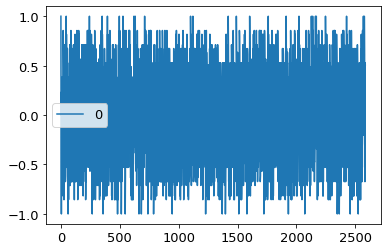

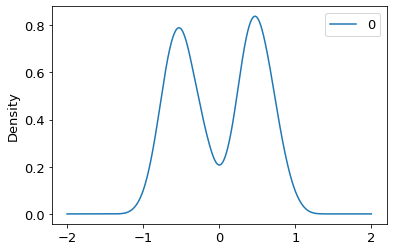

                  0
count  2.586000e+03
mean  -7.711181e-05
std    5.410035e-01
min   -1.000000e+00
25%   -5.085247e-01
50%    1.110223e-16
75%    4.909234e-01
max    1.000000e+00


In [291]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

arima = ARIMA(bin_y[:], order=(5,1,0))
arima_fit = arima.fit()
print(arima_fit.summary())
residuals = DataFrame(arima_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [345]:
def extract_peak(X):
    peaks = []
    for each in X:
        peaks.append(np.max(each))
    return peaks
def extract_trough(X):
    troughs = []
    for each in X:
        troughs.append(np.min(each[600:900]))
    return troughs
def extract_ptt_peak(X):
    ptts = []
    for each in X:
        ptts.append(np.max(each[600:900])-np.max(each[-300:]))
    return ptts
def extract_ptt_trough(X):
    ptts = []
    for each in X:
        ptts.append(np.min(each[600:900])-np.min(each[-300:]))
    return ptts
peaks=extract_peak(X)
troughs=extract_trough(X)
ptt_peaks=extract_ptt_peak(X)
ptt_troughs=extract_ptt_trough(X)

epoch=0.000000, predicted=0.745407, expected=0.746858
epoch=1.000000, predicted=0.747232, expected=0.746142


Maximum Likelihood optimization failed to converge. Check mle_retvals


epoch=4.000000, predicted=0.746262, expected=0.749320
epoch=9.000000, predicted=0.747170, expected=0.747069
epoch=24.000000, predicted=0.749132, expected=0.747537


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


epoch=49.000000, predicted=0.748560, expected=0.746997
Test RMSE: 0.002


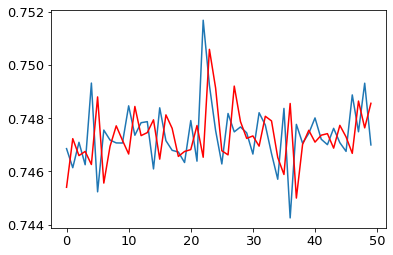

In [347]:
train, test = peaks[:1500], peaks[1500:1550]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    if len(test) % (1+t) == 0:
        print('epoch=%f, predicted=%f, expected=%f' % (t, yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Maximum Likelihood optimization failed to converge. Check mle_retvals


epoch=0.000000, predicted=0.744915, expected=123.489380
epoch=1.000000, predicted=351.708632, expected=127.410889


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


epoch=4.000000, predicted=297.418237, expected=122.665405


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


epoch=9.000000, predicted=52.336627, expected=124.328613
epoch=24.000000, predicted=120.032307, expected=123.931885
epoch=49.000000, predicted=130.467776, expected=132.171631
Test RMSE: 52.751


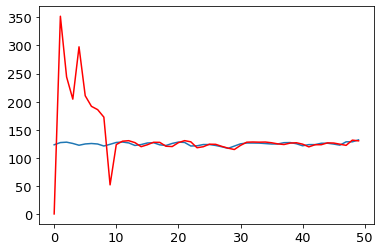

In [395]:
train, test = peaks[:1500], in_y[1500:1550]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    if len(test) % (t+1) == 0:
        print('epoch=%f, predicted=%f, expected=%f' % (t, yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

epoch=0.000000, predicted=0.192203, expected=73.745728
epoch=1.000000, predicted=236.240514, expected=72.494507
epoch=2.000000, predicted=32.393916, expected=73.364258
epoch=4.000000, predicted=50.996174, expected=70.556641
epoch=5.000000, predicted=74.954189, expected=69.061279
epoch=9.000000, predicted=78.004104, expected=80.032349
epoch=14.000000, predicted=84.305598, expected=83.816528
epoch=24.000000, predicted=79.577190, expected=79.589844
epoch=29.000000, predicted=81.953664, expected=83.160400
epoch=49.000000, predicted=86.222574, expected=83.648682
epoch=74.000000, predicted=79.367465, expected=77.789307
epoch=149.000000, predicted=83.289862, expected=86.090088
Test RMSE: 1.727


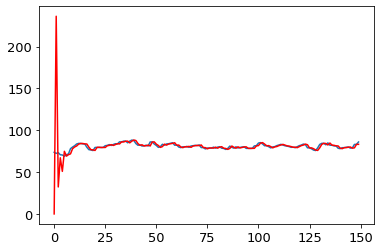

In [441]:
train, test = troughs[:1400], y[1400:1550,1]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    if len(test) % (t+1) == 0:
        print('epoch=%f, predicted=%f, expected=%f' % (t, yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test[5:], predictions[5:]))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [438]:
rmse = sqrt(mean_squared_error(test[10:], predictions[10:]))
rmse

1.6456898232073216

201 250
rmse=3.0316805589103972


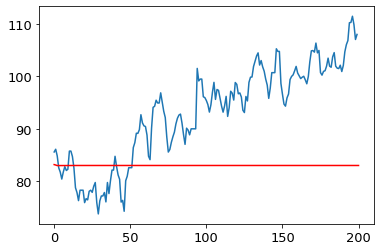

In [442]:
output = model_fit.predict(1550, 1750, dynamic=False)
print(len(output), len(y[1500:1750,1]))
pyplot.plot(y[1550:1750,1])
pyplot.plot(output, color='red')
print(f'rmse={sqrt(mean_squared_error(y[1510:1550,1], output[10:50]))}')

In [443]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1549
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3218.128
Date:                Wed, 18 May 2022   AIC                           6448.256
Time:                        16:25:24   BIC                           6480.324
Sample:                             0   HQIC                          6460.183
                               - 1549                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0079      0.065     -0.122      0.903      -0.135       0.119
ar.L2          0.0158      0.099      0.160      0.873      -0.178       0.209
ar.L3         -0.0358      0.119     -0.301      0.7

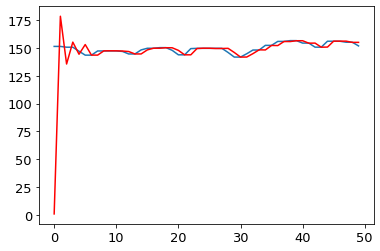

In [361]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [375]:
mbp=get_mbp(sbp, dbp)

In [380]:
mbp

[0.5667780602808613,
 155.40948761513036,
 116.37441745206733,
 135.4518615843028,
 125.17564515809983,
 132.77373298311036,
 125.71733389930966,
 125.67609117219591,
 128.2879948061347,
 128.29155382558295,
 128.97300166337575,
 128.84234507456995,
 128.5430094743939,
 127.76151424117059,
 127.77943296685783,
 129.8359690926431,
 131.44400185490323,
 131.4473824449616,
 132.19828283604497,
 132.1372417900634,
 130.01796243554148,
 126.68167351237035,
 126.70789054035782,
 129.94779481797988,
 130.17552433238262,
 130.12727576112067,
 129.998158995816,
 129.97625006529796,
 130.07242938412392,
 127.18002595476257,
 123.86556816233148,
 123.87803345275178,
 127.08299387553218,
 128.5448443854751,
 128.49348380047056,
 132.85912323948193,
 132.81126742099147,
 135.2469154885358,
 135.18079431970503,
 136.8449934552631,
 136.81914067285544,
 134.47917644048337,
 134.5278425042675,
 131.88654309892374,
 131.96646178952577,
 134.70272763854027,
 134.72277244681723,
 134.7123256908038,
 134.

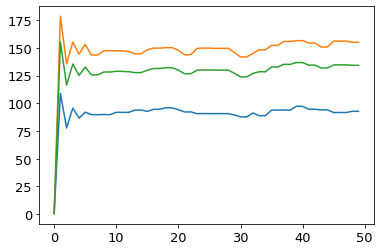

In [381]:
plt.plot(dbp)
plt.plot(sbp)
plt.plot(mbp)

In [379]:
def get_mbp(sbp, dbp):
    mbp = []
    for i, e in enumerate(sbp):
        mbp.append((sbp[i]+sbp[i]+dbp[i])/3)
        print(sbp[i], dbp[i], mbp[i])
    return mbp

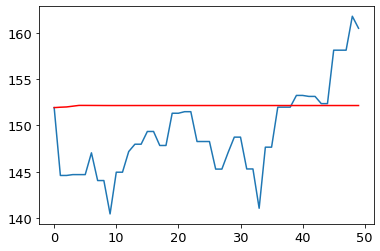

In [364]:
model = ARIMA(history, order=(5,1,0))
model_fit = model.fit()
output = model_fit.forecast(50)
pyplot.plot(y[2550:2600,0])
pyplot.plot(output, color='red')

In [363]:
len(history)

2550